In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import classify_old
import preprocess_old

np.random.seed(42)
random.seed(42)


In [2]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')

        #y_pred, feature_importance_all = classify.log_regression_no_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')

        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')


        


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [51]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]
print(activity.shape)

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

print(trial_r_1, trial_r_2)

print(mean_activity_r_1.shape, mean_activity_r_2.shape)


TypeError: list indices must be integers or slices, not str

# Raw traces

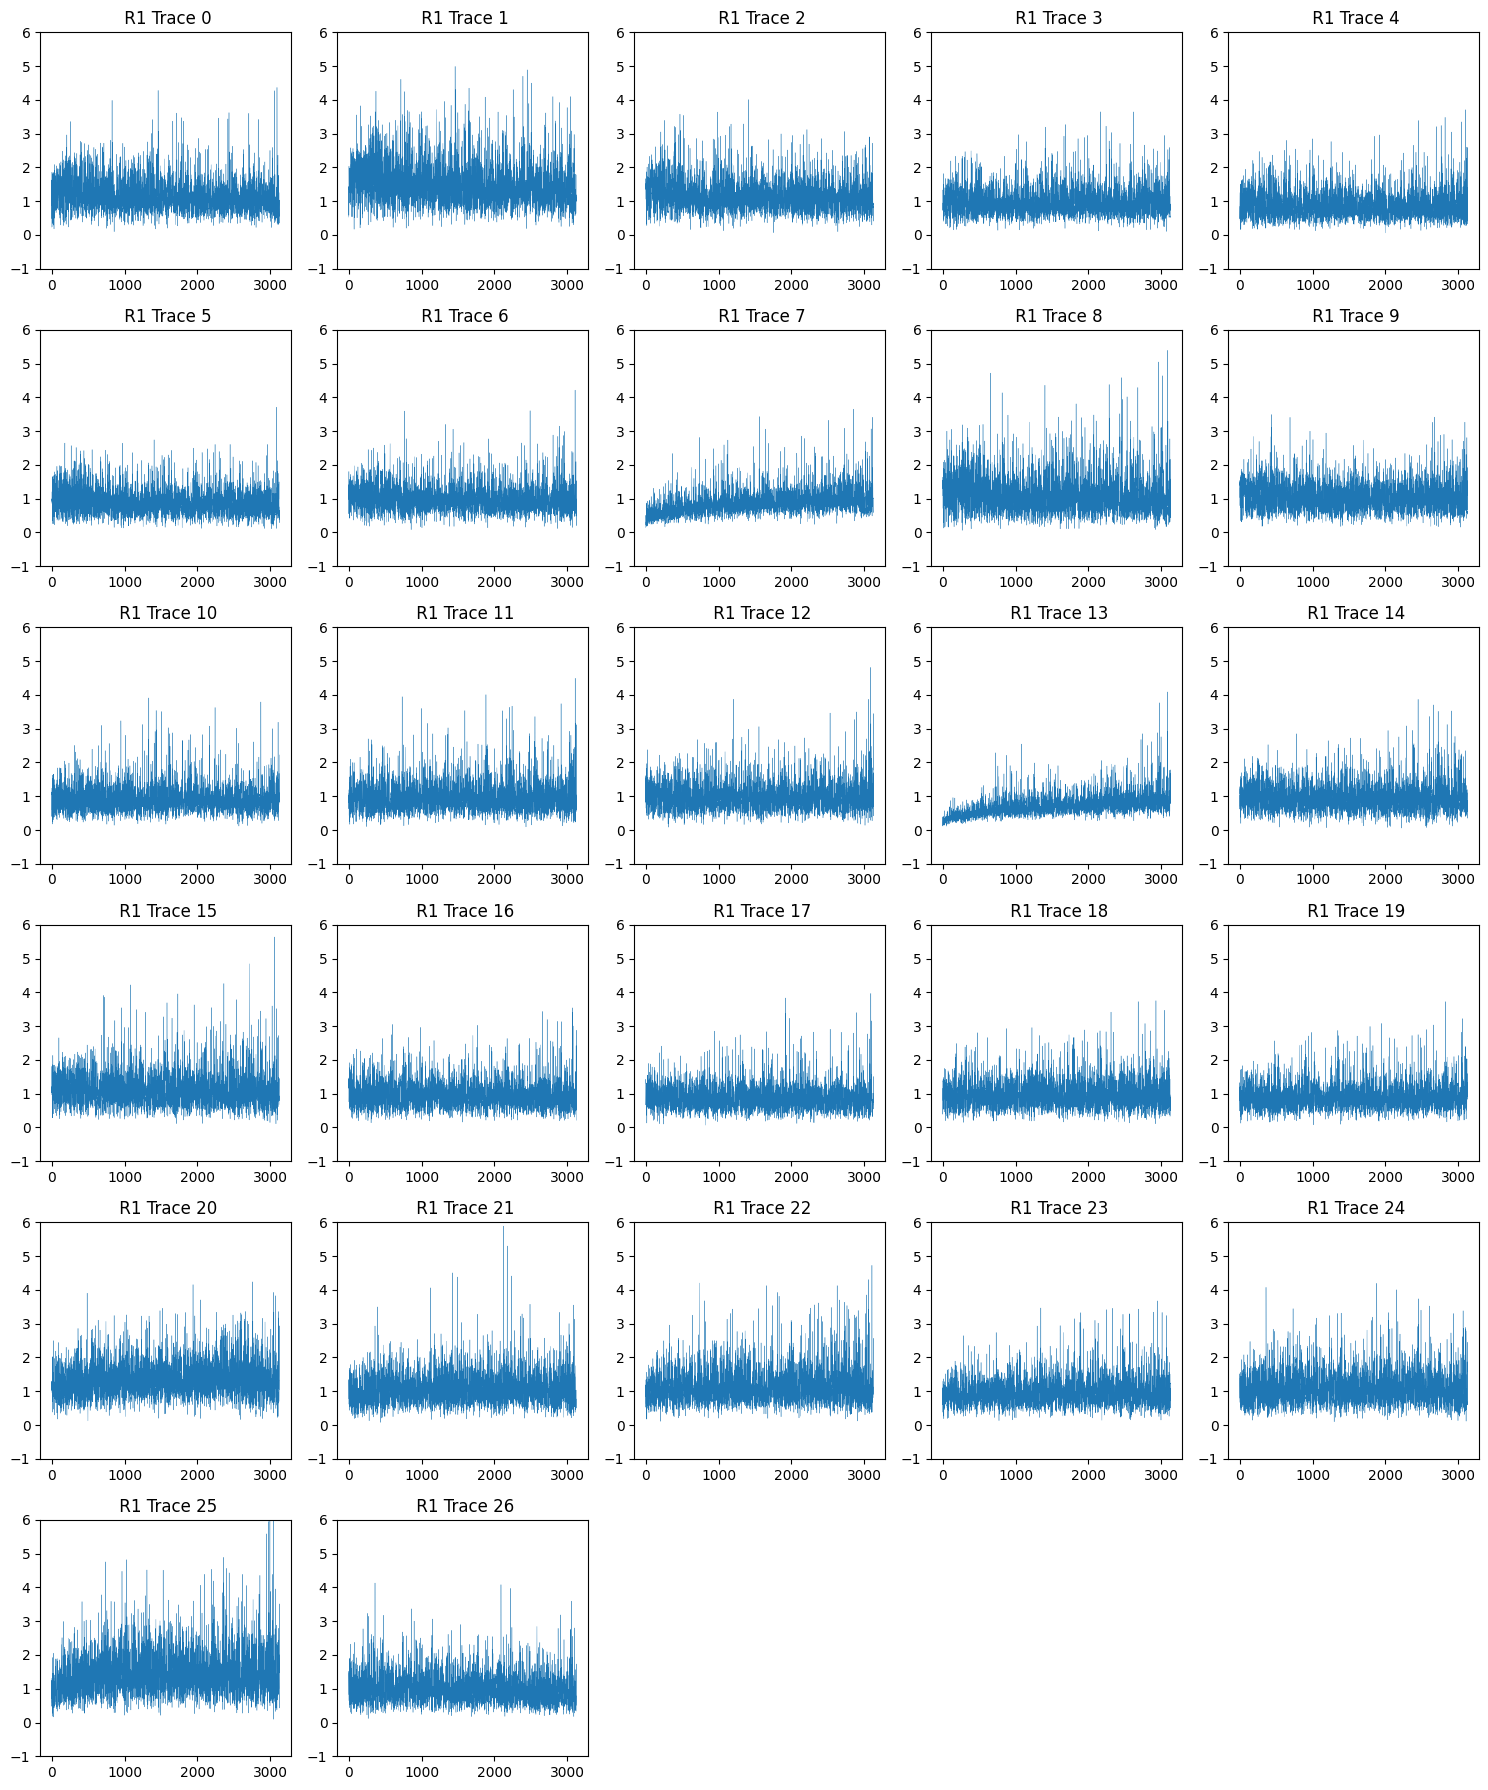

In [5]:
n_traces = mean_activity_r_1.shape[0]
cols = 5  # Number of plots per row
rows = math.ceil(n_traces / cols)


fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()  

for i in range(n_traces):
    axes[i].plot(mean_activity_r_1[i, :], lw=.25)
    axes[i].set_title(f" R1 Trace {i}")
    axes[i].set_ylim(-1, 6)
for j in range(n_traces, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


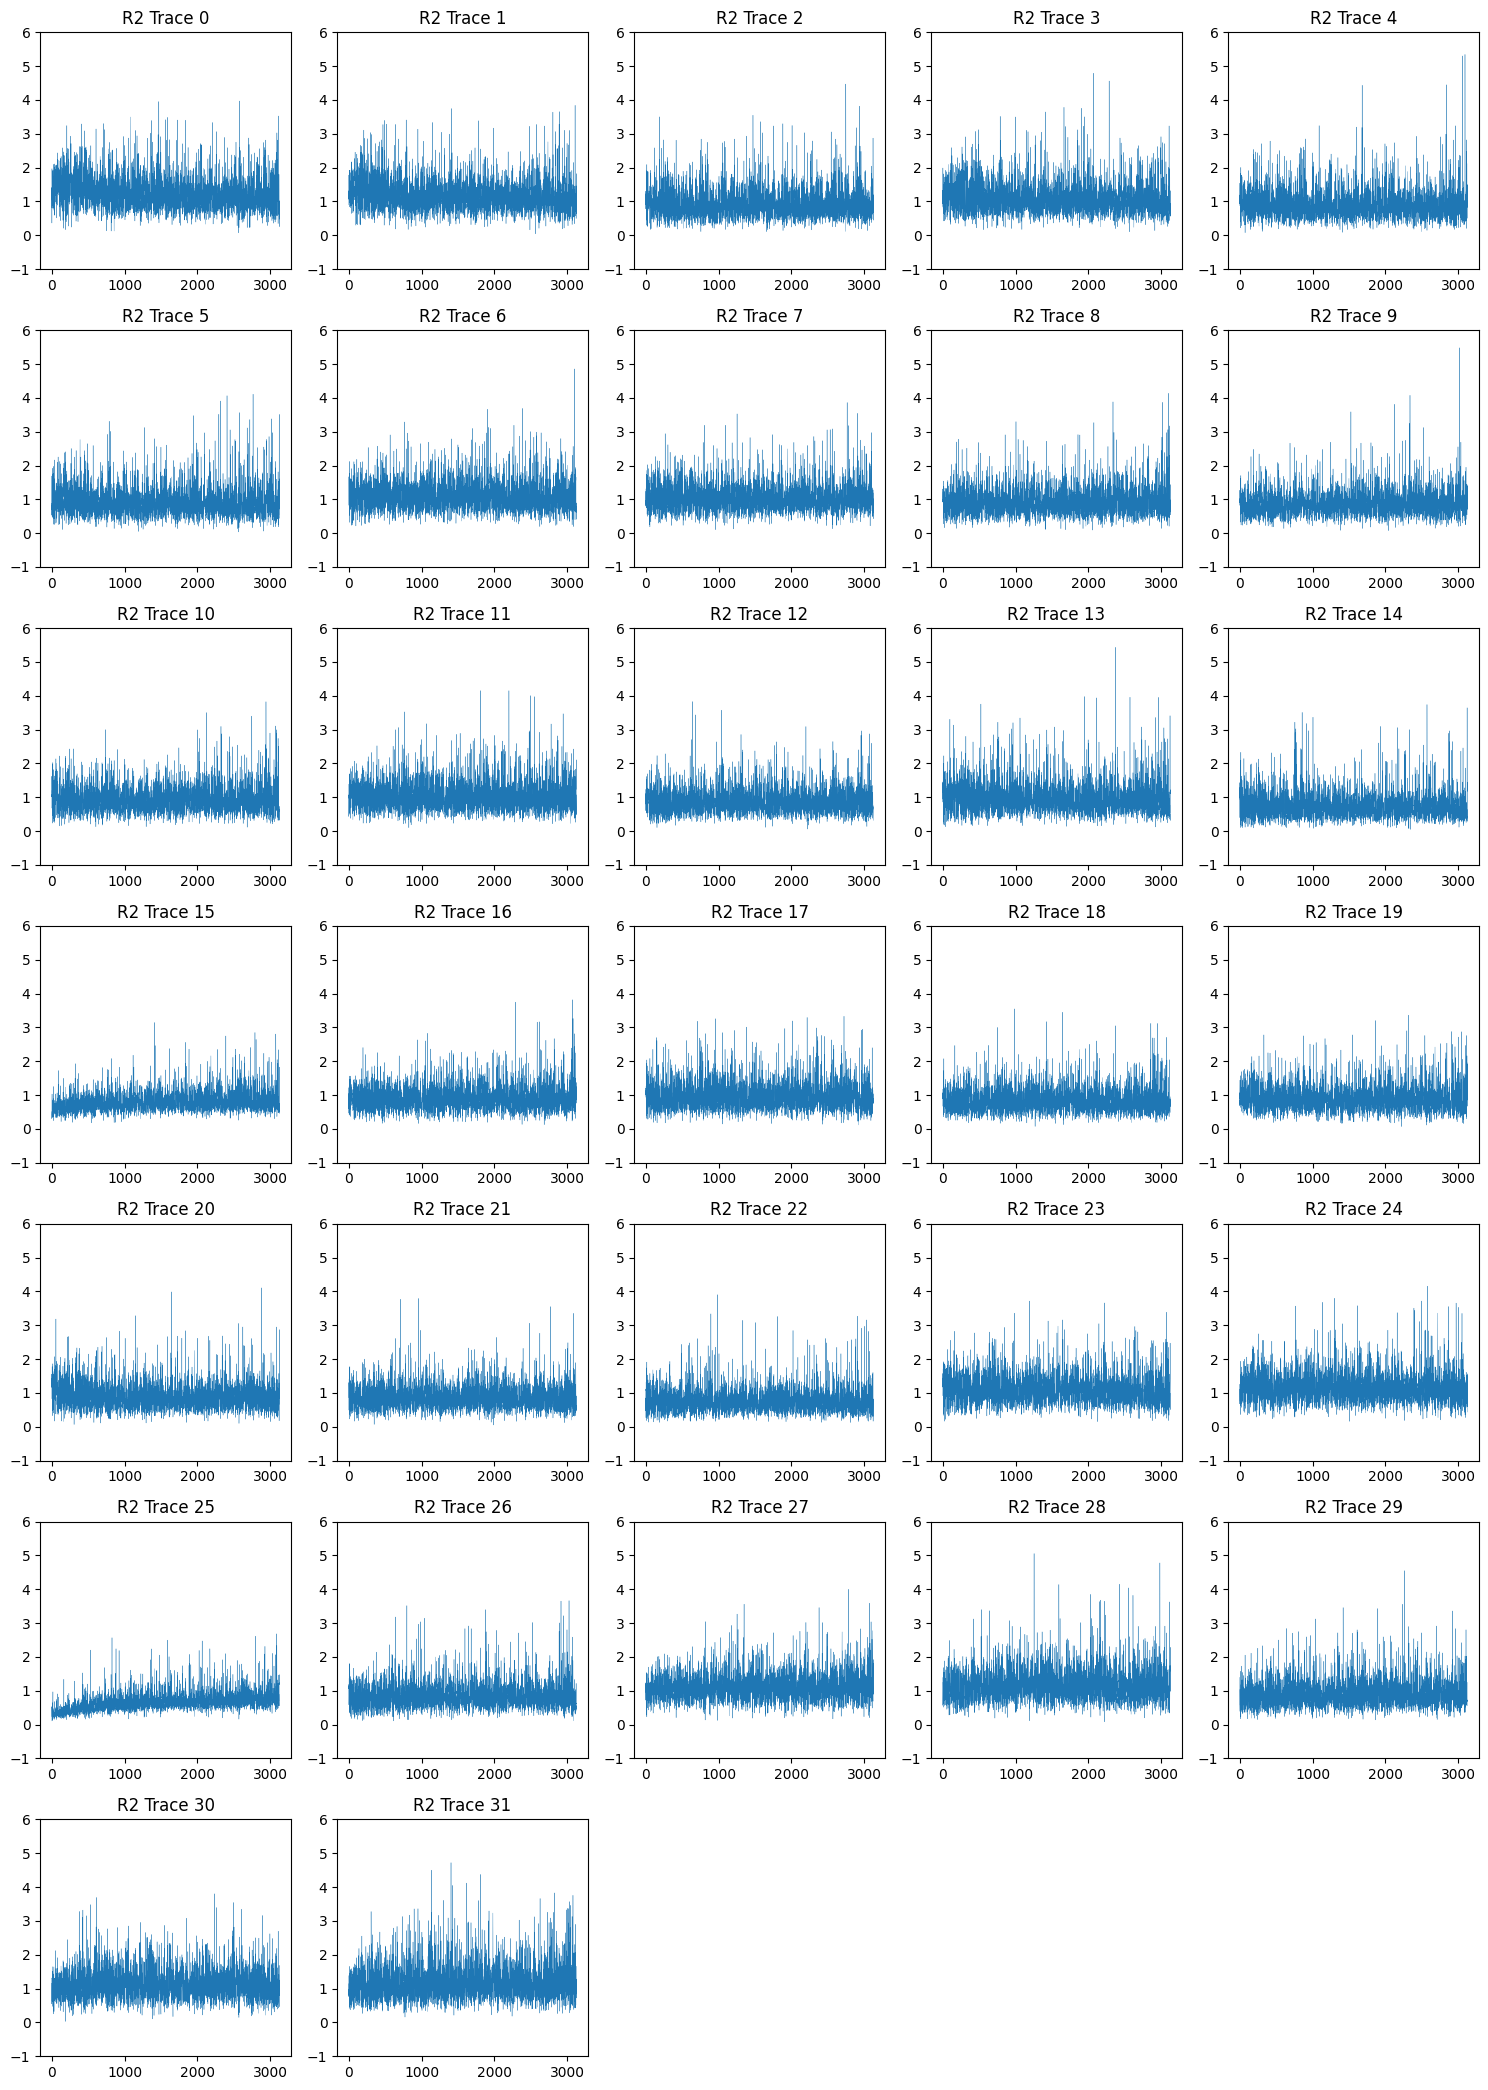

In [6]:
n_traces = mean_activity_r_2.shape[0]
cols = 5  # Number of plots per row
rows = math.ceil(n_traces / cols)


fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()  

for i in range(n_traces):
    axes[i].plot(mean_activity_r_2[i, :], lw=.25)
    axes[i].set_title(f"R2 Trace {i}")
    axes[i].set_ylim(-1, 6)

for j in range(n_traces, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [56]:
p_threshold = 0.75

r1_traces = {}  
r2_traces = {}  
trace_index_r1 = 0 
trace_index_r2 = 0  

cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

while i < len(reactivation_cs_1) - 1:
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation probabilities
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
    
        # Check if reactivation event has ended
        if reactivation_cs_1[i + 1] <= 0.01 and reactivation_cs_2[i + 1] <= 0.01:
            r_end = i + 1
            next_r = 0

            # Compute a time vector for this event (in seconds)
            time_vector = np.arange(r_start, r_end) / behavior['framerate']

            if cs_1_peak > p_threshold:
                # Loop through onsets, starting at index 1 to allow j-1
                for j in range(1, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and \
                       r_start < onsets_cs_1[j-1] + int(behavior['framerate'] * 61):
                        # Extract raw activity trace for this reactivation event
                        r1_trace = activity[:, r_start:r_end]
                        print("CS1 trace shape:", r1_trace.shape)
                        # Store both the time vector and trace in the dictionary
                        r1_traces[trace_index_r1] = {'time': time_vector, 'trace': r1_trace}
                        trace_index_r1 += 1

            if cs_2_peak > p_threshold:
                for j in range(1, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and \
                       r_start < onsets_cs_2[j-1] + int(behavior['framerate'] * 61):
                        r2_trace = activity[:, r_start:r_end]
                        print("CS2 trace shape:", r2_trace.shape)
                        r2_traces[trace_index_r2] = {'time': time_vector, 'trace': r2_trace}
                        trace_index_r2 += 1

            # Reset for next event and jump ahead in the index
            cs_1_peak = 0
            cs_2_peak = 0
            i = r_end
            continue  # Skip incrementing i to avoid missing events
    i += 1

if r1_traces:
    # Concatenate traces along the time axis (axis=1) to get a comprehensive baseline for each neuron.
    all_r1 = np.concatenate([r1_traces[key]['trace'] for key in r1_traces], axis=1)
    baseline_r1 = np.mean(all_r1, axis=1)  # shape: (neurons,)
    # Normalize each CS1 trace
    for key in r1_traces:
        r1_traces[key]['trace_normalized'] = r1_traces[key]['trace'] / baseline_r1[:, None]

# For CS2 traces: compute baseline for each neuron across all CS2 reactivation traces
if r2_traces:
    all_r2 = np.concatenate([r2_traces[key]['trace'] for key in r2_traces], axis=1)
    baseline_r2 = np.mean(all_r2, axis=1)
    # Normalize each CS2 trace
    for key in r2_traces:
        r2_traces[key]['trace_normalized'] = r2_traces[key]['trace'] / baseline_r2[:, None]

# both r1_traces and r2_traces contain:
#   - 'time': the time vector for the event,
#   - 'trace': the raw activity trace,
#   - 'trace_normalized': the activity normalized by the mean across events.


CS1 trace shape: (6779, 82)
CS1 trace shape: (6779, 85)
CS2 trace shape: (6779, 82)
CS2 trace shape: (6779, 85)
CS1 trace shape: (6779, 73)
CS2 trace shape: (6779, 62)
CS2 trace shape: (6779, 86)
CS2 trace shape: (6779, 68)
CS2 trace shape: (6779, 69)
CS2 trace shape: (6779, 71)
CS1 trace shape: (6779, 75)
CS2 trace shape: (6779, 78)
CS2 trace shape: (6779, 46)
CS1 trace shape: (6779, 14)
CS1 trace shape: (6779, 70)
CS1 trace shape: (6779, 53)
CS1 trace shape: (6779, 25)
CS2 trace shape: (6779, 76)
CS1 trace shape: (6779, 9)
CS1 trace shape: (6779, 70)
CS1 trace shape: (6779, 62)
CS1 trace shape: (6779, 54)
CS2 trace shape: (6779, 8)
CS1 trace shape: (6779, 25)
CS1 trace shape: (6779, 27)
CS1 trace shape: (6779, 12)
CS1 trace shape: (6779, 19)
CS1 trace shape: (6779, 10)
CS1 trace shape: (6779, 21)
CS1 trace shape: (6779, 26)
CS2 trace shape: (6779, 69)
CS1 trace shape: (6779, 68)
CS1 trace shape: (6779, 79)
CS2 trace shape: (6779, 43)
CS2 trace shape: (6779, 26)
CS1 trace shape: (6779

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


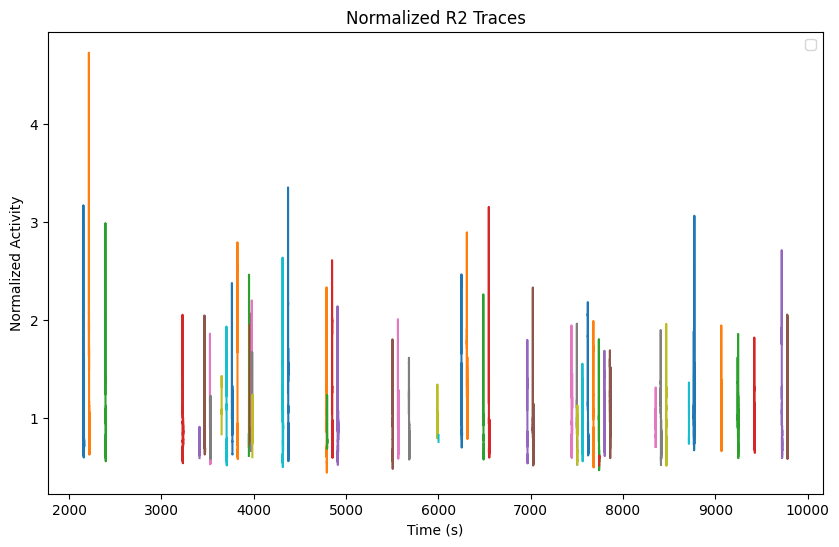

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


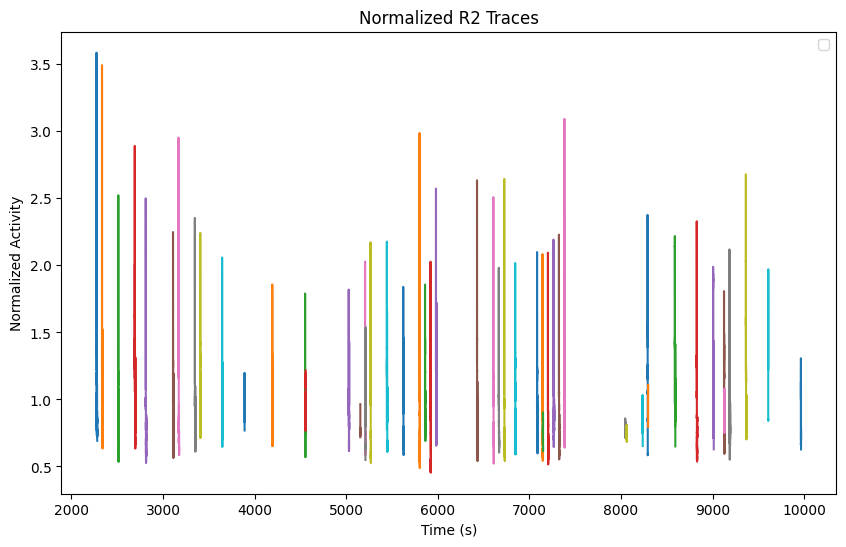

In [63]:

plt.figure(figsize=(10, 6))
for key in sorted(r1_traces.keys()):

    data = r1_traces[key]
    time_vector = np.squeeze(data['time'])
    mean_activity = np.mean(data['trace_normalized'], axis=0)
    plt.plot(time_vector, mean_activity)

plt.xlabel("Time (s)")
plt.ylabel("Normalized Activity")
plt.title("Normalized R2 Traces")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for key in sorted(r2_traces.keys()):

    data = r2_traces[key]
    time_vector = np.squeeze(data['time'])
    mean_activity = np.mean(data['trace_normalized'], axis=0)
    plt.plot(time_vector, mean_activity)

plt.xlabel("Time (s)")
plt.ylabel("Normalized Activity")
plt.title("Normalized R2 Traces")
plt.legend()
plt.show()

In [57]:
print(behavior["onsets"])

[[ 21833]
 [ 22456]
 [ 23075]
 [ 23694]
 [ 24316]
 [ 24938]
 [ 25553]
 [ 26170]
 [ 26794]
 [ 27415]
 [ 28041]
 [ 28662]
 [ 29287]
 [ 29912]
 [ 30529]
 [ 31150]
 [ 31773]
 [ 32391]
 [ 33017]
 [ 33641]
 [ 34255]
 [ 34874]
 [ 35490]
 [ 36114]
 [ 36734]
 [ 37353]
 [ 37974]
 [ 38594]
 [ 39214]
 [ 39834]
 [ 40456]
 [ 41079]
 [ 43058]
 [ 43680]
 [ 44306]
 [ 44927]
 [ 45544]
 [ 46169]
 [ 46787]
 [ 47411]
 [ 48031]
 [ 48649]
 [ 49272]
 [ 49890]
 [ 50510]
 [ 51130]
 [ 51745]
 [ 52371]
 [ 52988]
 [ 53612]
 [ 54231]
 [ 54854]
 [ 55471]
 [ 56088]
 [ 56710]
 [ 57329]
 [ 57946]
 [ 58572]
 [ 59189]
 [ 59808]
 [ 60424]
 [ 61050]
 [ 61676]
 [ 62294]
 [ 64484]
 [ 65107]
 [ 65722]
 [ 66344]
 [ 66962]
 [ 67579]
 [ 68199]
 [ 68819]
 [ 69439]
 [ 70058]
 [ 70679]
 [ 71302]
 [ 71922]
 [ 72543]
 [ 73166]
 [ 73790]
 [ 74411]
 [ 75029]
 [ 75655]
 [ 76278]
 [ 76902]
 [ 77521]
 [ 78136]
 [ 78756]
 [ 79370]
 [ 79993]
 [ 80617]
 [ 81238]
 [ 81862]
 [ 82484]
 [ 83106]
 [ 83726]
 [ 85735]
 [ 86357]
 [ 86974]
 [ 87597]


# Cossims

Slope: 0.000507717378700832
P-value: 0.00042152777821315694
The regression line significantly changes over time (p < 0.01).


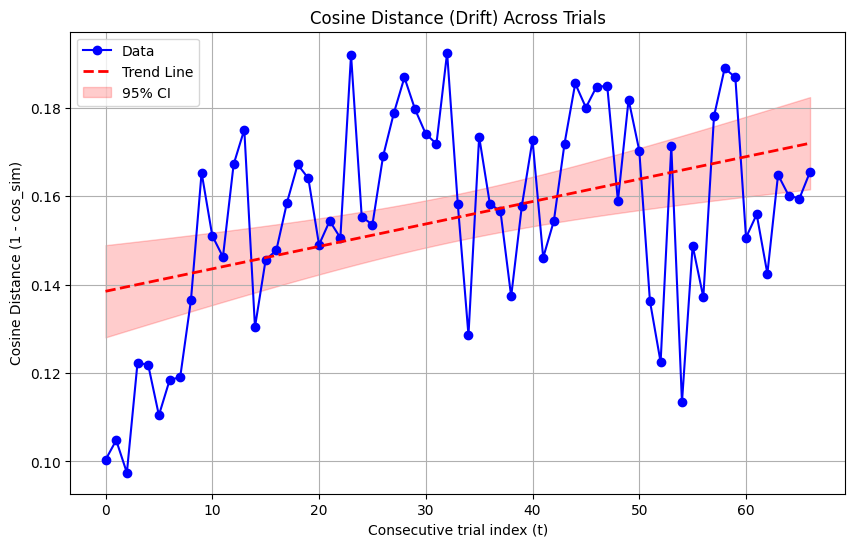

Slope: 0.0005049486111009546
P-value: 0.019555960521146925
The regression line does not significantly change over time (p >= 0.01).


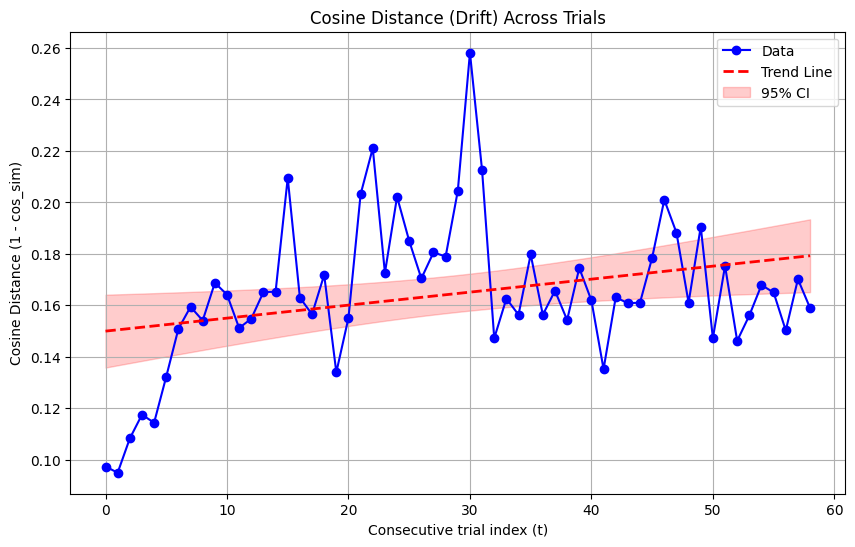

Slope: 0.00104725732094128
P-value: 0.11818627608838017
The regression line does not significantly change over time (p >= 0.01).


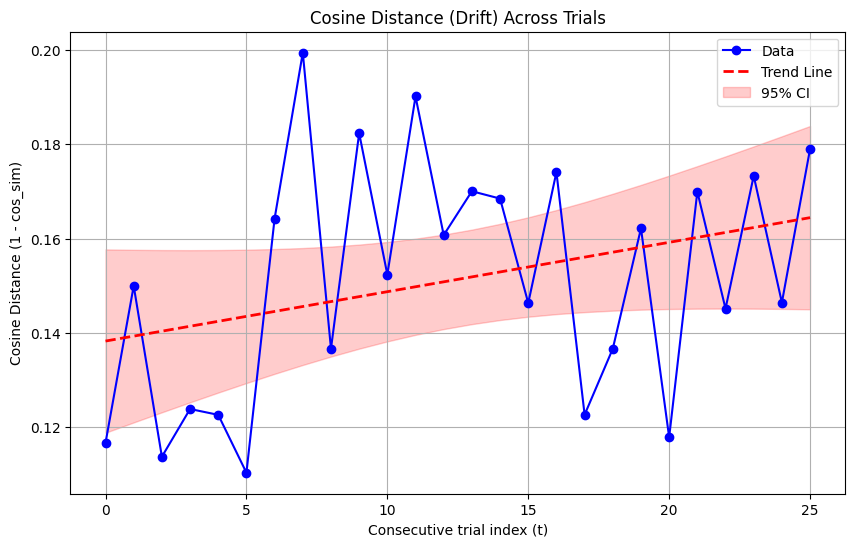

Slope: -0.0008190955419020262
P-value: 0.17418124764507475
The regression line does not significantly change over time (p >= 0.01).


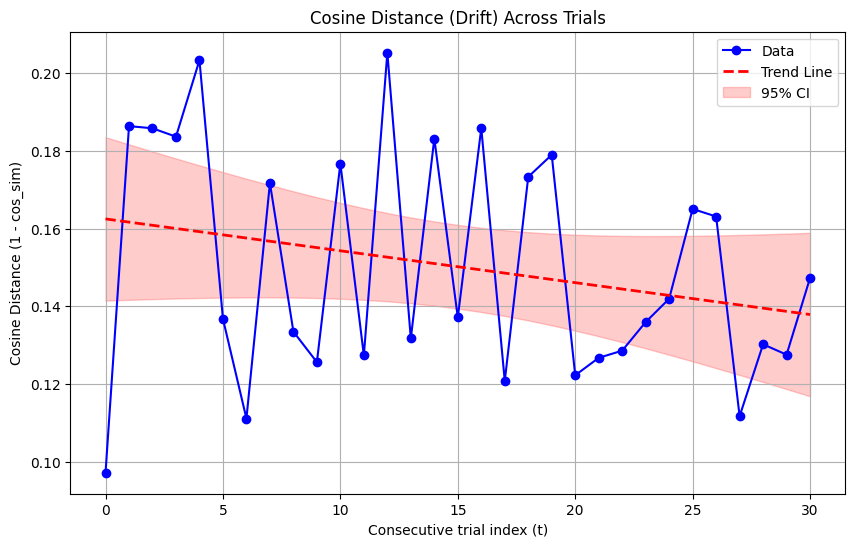

In [12]:
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import t as t_dist


def compute_drift_cosine(mean_activity, confidence=0.95, measure="distance"):
    """
    Computes a drift metric based on consecutive-trial cosine similarity.
    
    Parameters
    ----------
    mean_activity : ndarray of shape (num_trials, num_neurons)
        mean_activity[t] is the activity vector for trial t across all neurons.
    
    confidence : float, optional
        Confidence level for confidence intervals. Default is 0.95 (95% CI).
    
    measure : {'distance', 'similarity'}, optional
        Whether to return cosine distance (drift) or cosine similarity.
        - 'distance' -> 1 - cos_sim
        - 'similarity' -> cos_sim
    
    Returns
    -------
    drift_values : ndarray
        An array of length (num_trials - 1) containing the drift or similarity
        between consecutive trials.
    """

    # Number of trials
    n_trials = mean_activity.shape[0]
    
    # Compute cosine similarity for each pair of consecutive trials
    cos_sims = []
    for t in range(n_trials - 1):
        vec_t = mean_activity[t]
        vec_tp1 = mean_activity[t+1]
        
        # Safeguard against zero-norm vectors
        denom = (norm(vec_t) * norm(vec_tp1))
        if denom == 0:
            cos_sims.append(np.nan)
        else:
            cos_sim = np.dot(vec_t, vec_tp1) / denom
            cos_sims.append(cos_sim)
    
    cos_sims = np.array(cos_sims)
    
    if measure == "distance":
        # Cosine distance = 1 - cosine similarity
        drift_values = 1 - cos_sims
        y_label = "Cosine Distance (1 - cos_sim)"
        title_str = "Cosine Distance (Drift) Across Trials"
    else:
        # Directly use cosine similarity
        drift_values = cos_sims
        y_label = "Cosine Similarity"
        title_str = "Cosine Similarity Across Trials"

    # Print the drift/similarity values
    #print(f"{measure.capitalize()} values between consecutive trials:")
    #print(drift_values)

    # Prepare data for linear regression
    x = np.arange(len(drift_values)).reshape(-1, 1)
    y = drift_values

    # Fit a linear regression model
    reg_model = LinearRegression()
    reg_model.fit(x, y)
    y_trend = reg_model.predict(x)

    # Get slope, intercept, etc. via linregress
    slope, intercept, r_value, p_value, std_err = linregress(x.flatten(), y)
    print(f"Slope: {slope}")
    print(f"P-value: {p_value}")

    if p_value < 0.01:
        print("The regression line significantly changes over time (p < 0.01).")
    else:
        print("The regression line does not significantly change over time (p >= 0.01).")

    # Calculate confidence intervals for the trend line
    n = len(y)
    dof = n - 2  # degrees of freedom
    t_crit = t_dist.ppf((1 + confidence) / 2, dof)  # critical t-value for given confidence level

    # Standard error of predicted values
    residuals = y - y_trend
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    # Compute confidence interval for each predicted point
    x_mean = np.mean(x)
    x_var = np.sum((x.flatten() - x_mean)**2)
    ci = t_crit * s_err * np.sqrt(1/n + ((x.flatten() - x_mean)**2 / x_var))

    upper_bound = y_trend.flatten() + ci
    lower_bound = y_trend.flatten() - ci

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(drift_values, marker='o', linestyle='-', color='blue', label='Data')
    plt.plot(x.flatten(), y_trend, color='red', linestyle='--', linewidth=2, label='Trend Line')
    plt.fill_between(x.flatten(), lower_bound, upper_bound, color='red', alpha=0.2, 
                     label=f"{int(confidence * 100)}% CI")
    plt.xlabel('Consecutive trial index (t)')
    plt.ylabel(y_label)
    plt.title(title_str)
    plt.grid(True)
    plt.legend()
    plt.show()

    #return drift_values


compute_drift_cosine(mean_activity_cs_1)
compute_drift_cosine(mean_activity_cs_2)

compute_drift_cosine(mean_activity_r_1)
compute_drift_cosine(mean_activity_r_2)



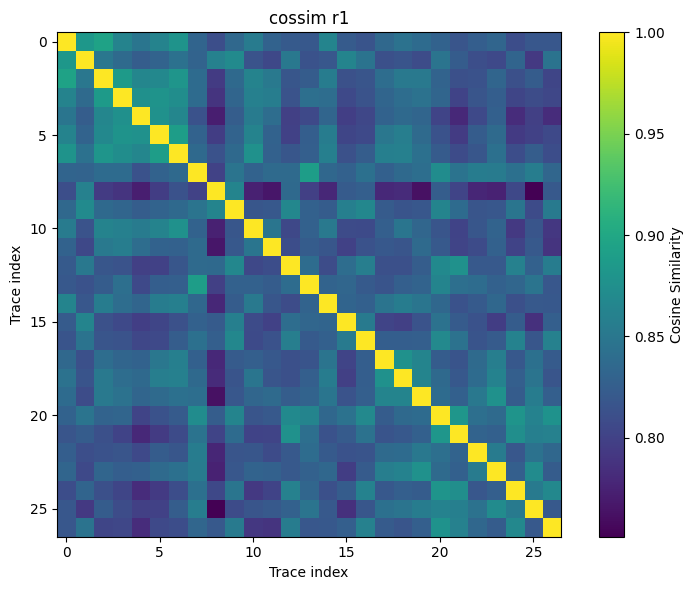

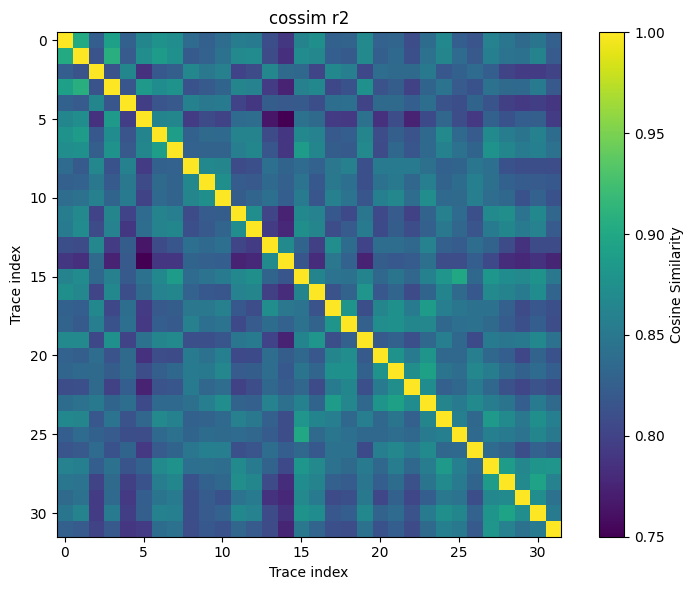

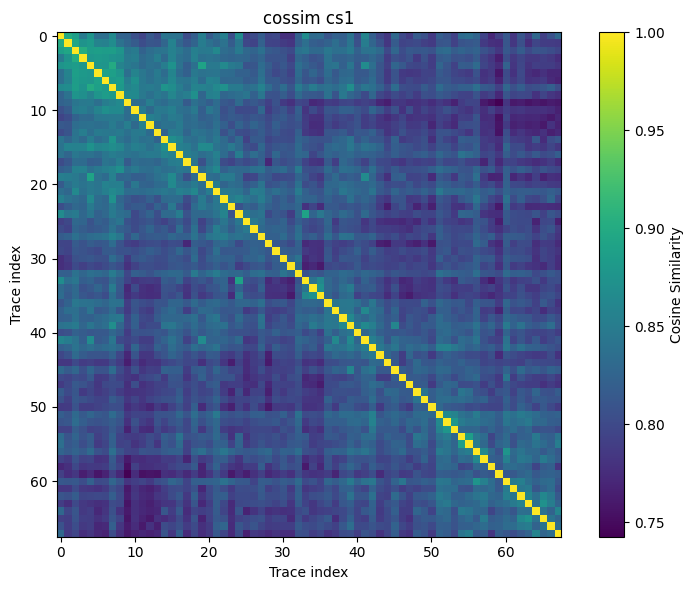

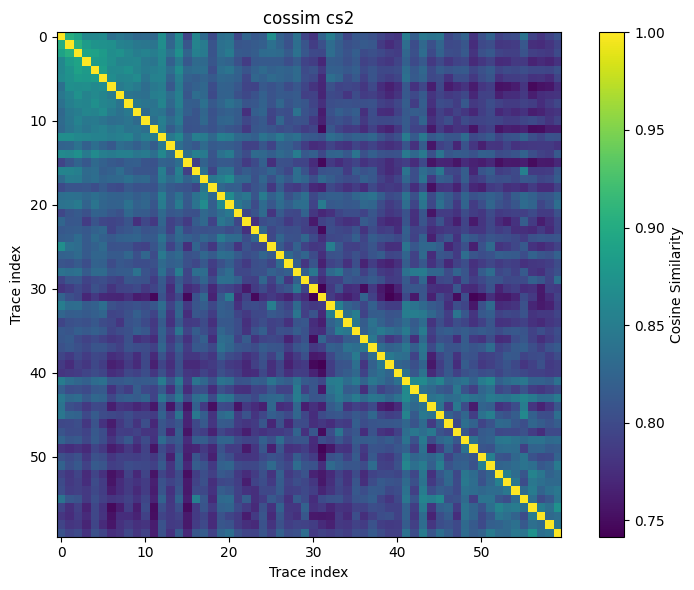

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix_r1 = cosine_similarity(mean_activity_r_1)
cos_sim_matrix_r2 = cosine_similarity(mean_activity_r_2)

cos_sim_matrix_cs1 = cosine_similarity(mean_activity_cs_1)
cos_sim_matrix_cs2 = cosine_similarity(mean_activity_cs_2)


plt.figure(figsize=(8, 6))
plt.imshow(cos_sim_matrix_r1, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('cossim r1')
plt.xlabel('Trace index')
plt.ylabel('Trace index')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cos_sim_matrix_r2, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('cossim r2')
plt.xlabel('Trace index')
plt.ylabel('Trace index')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cos_sim_matrix_cs1, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('cossim cs1')
plt.xlabel('Trace index')
plt.ylabel('Trace index')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cos_sim_matrix_cs2, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('cossim cs2')
plt.xlabel('Trace index')
plt.ylabel('Trace index')
plt.tight_layout()
plt.show()






# cross-correlation

In [17]:
print(mean_activity_cs_1.shape,mean_activity_cs_2.shape)
print(mean_activity_r_1.shape,mean_activity_r_2.shape)

(68, 3124) (60, 3124)
(27, 3124) (32, 3124)


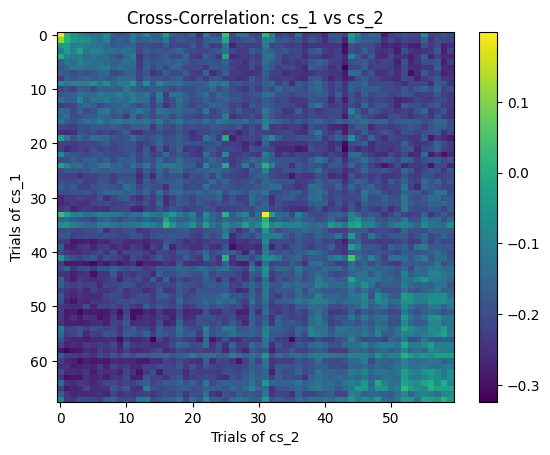

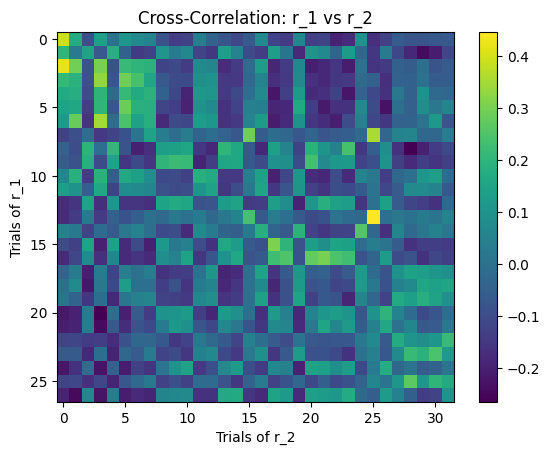

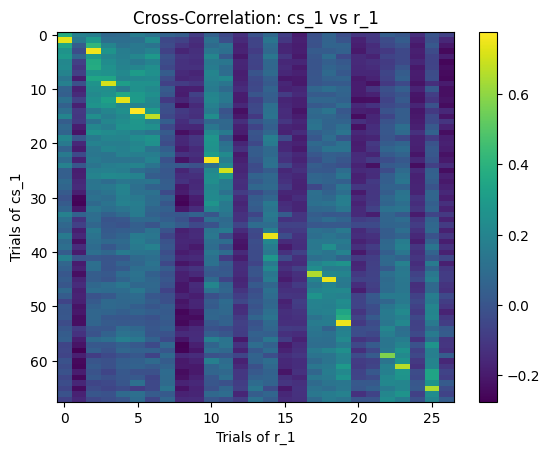

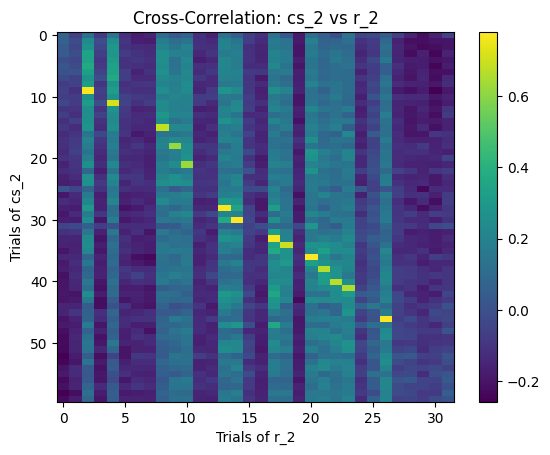

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def compute_cross_corr(data1, data2):
    combined = np.vstack((data1, data2))
    corr_all = np.corrcoef(combined)
    n1 = data1.shape[0]
    cross_corr = corr_all[:n1, n1:]
    return cross_corr

corr_cs = compute_cross_corr(mean_activity_cs_1, mean_activity_cs_2)

corr_r = compute_cross_corr(mean_activity_r_1, mean_activity_r_2)

corr_cs_r1 = compute_cross_corr(mean_activity_cs_1, mean_activity_r_1)

corr_cs_r2 = compute_cross_corr(mean_activity_cs_2, mean_activity_r_2)

def plot_corr_matrix(corr_matrix, title, xlabel, ylabel):
    plt.figure()
    plt.imshow(corr_matrix, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_corr_matrix(corr_cs, 'Cross-Correlation: cs_1 vs cs_2', 'Trials of cs_2', 'Trials of cs_1')
plot_corr_matrix(corr_r, 'Cross-Correlation: r_1 vs r_2', 'Trials of r_2', 'Trials of r_1')
plot_corr_matrix(corr_cs_r1, 'Cross-Correlation: cs_1 vs r_1', 'Trials of r_1', 'Trials of cs_1')
plot_corr_matrix(corr_cs_r2, 'Cross-Correlation: cs_2 vs r_2', 'Trials of r_2', 'Trials of cs_2')


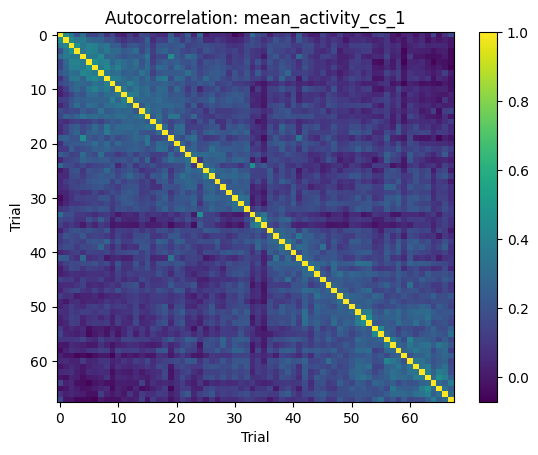

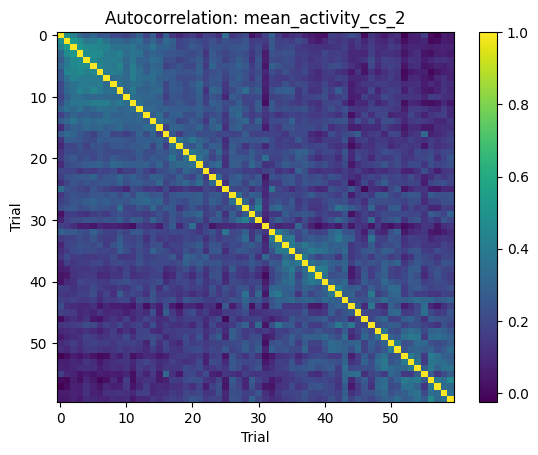

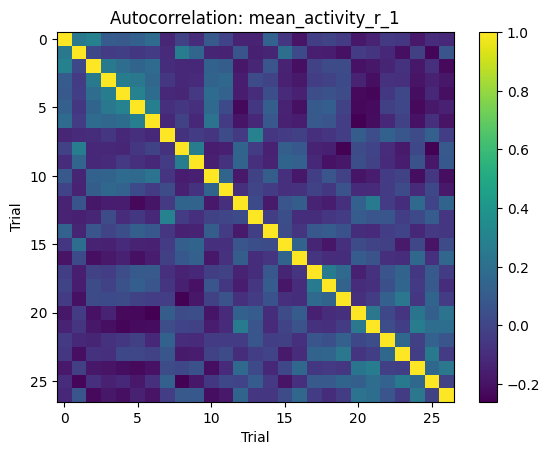

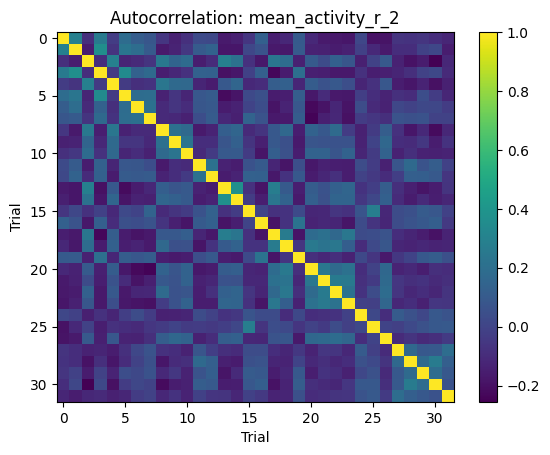

In [28]:
auto_cs1 = np.corrcoef(mean_activity_cs_1)
auto_cs2 = np.corrcoef(mean_activity_cs_2)
auto_r1  = np.corrcoef(mean_activity_r_1)
auto_r2  = np.corrcoef(mean_activity_r_2)

# Function to plot a heatmap of a correlation matrix:
def plot_corr_matrix(corr_matrix, title, xlabel, ylabel):
    plt.figure()
    plt.imshow(corr_matrix, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_corr_matrix(auto_cs1, 'Autocorrelation: mean_activity_cs_1', 'Trial', 'Trial')
plot_corr_matrix(auto_cs2, 'Autocorrelation: mean_activity_cs_2', 'Trial', 'Trial')
plot_corr_matrix(auto_r1,  'Autocorrelation: mean_activity_r_1',  'Trial', 'Trial')
plot_corr_matrix(auto_r2,  'Autocorrelation: mean_activity_r_2',  'Trial', 'Trial')


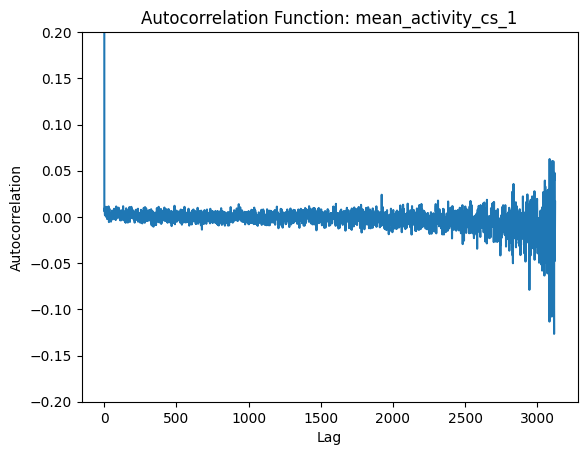

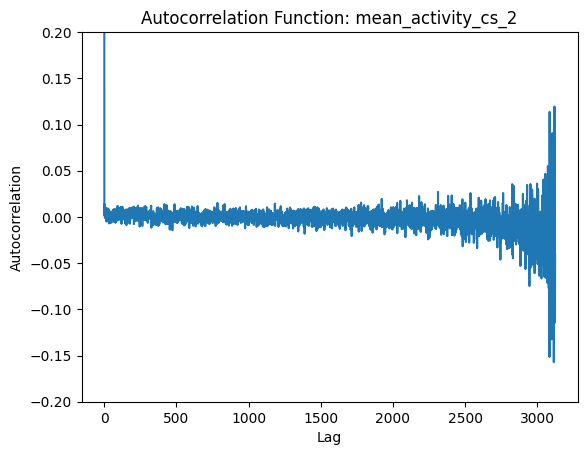

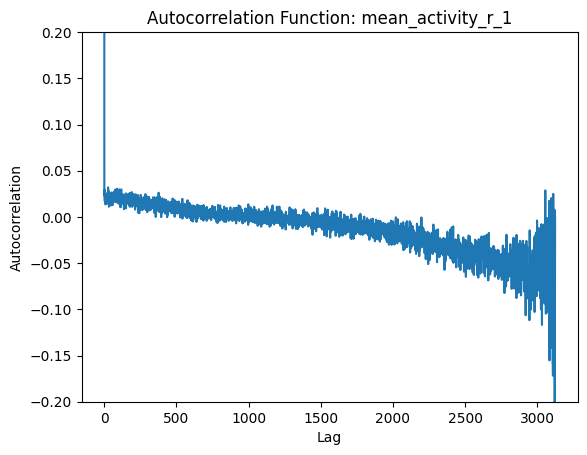

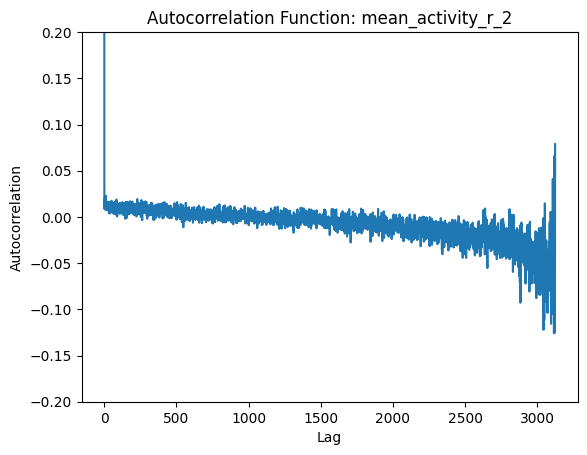

In [33]:

def autocorr_1d(x):
    """
    Compute the autocorrelation function of a 1D array.
    This function subtracts the mean, computes the full correlation,
    and then normalizes by the variance and the decreasing number of overlapping points.
    """
    n = len(x)
    variance = x.var()
    x = x - x.mean()
    r = np.correlate(x, x, mode='full')[-n:]
    result = r / (variance * np.arange(n, 0, -1))
    return result

# Compute average autocorrelation function for each condition:
auto_func_cs1 = np.mean([autocorr_1d(trial) for trial in mean_activity_cs_1], axis=0)
auto_func_cs2 = np.mean([autocorr_1d(trial) for trial in mean_activity_cs_2], axis=0)
auto_func_r1  = np.mean([autocorr_1d(trial) for trial in mean_activity_r_1], axis=0)
auto_func_r2  = np.mean([autocorr_1d(trial) for trial in mean_activity_r_2], axis=0)

plt.figure()
plt.plot(auto_func_cs1)
plt.title('Autocorrelation Function: mean_activity_cs_1')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-0.2, 0.2)
plt.show()

plt.figure()
plt.plot(auto_func_cs2)
plt.title('Autocorrelation Function: mean_activity_cs_2')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-0.2, 0.2)
plt.show()

plt.figure()
plt.plot(auto_func_r1)
plt.title('Autocorrelation Function: mean_activity_r_1')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-0.2, 0.2)
plt.show()

plt.figure()
plt.plot(auto_func_r2)
plt.title('Autocorrelation Function: mean_activity_r_2')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-0.2, 0.2)
plt.show()


t-SNE Analysis for Reactivation Data:

t-SNE Analysis for SER Data:
t-SNE results shapes: (59, 2) (128, 2)


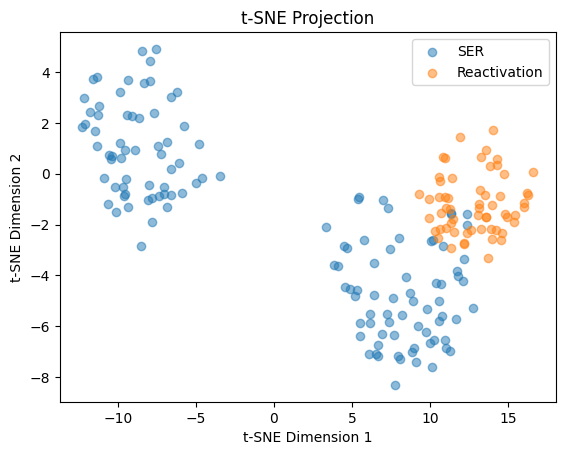

In [26]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Function to perform t-SNE on input data
def perform_tsne(data, n_components=2, perplexity=30, random_state=42):
    """
    Performs t-SNE on the input data.

    Parameters:
    - data: 2D numpy array (samples, features)
    - n_components: number of dimensions for the embedding (default = 2)
    - perplexity: t-SNE perplexity parameter (default = 30)
    - random_state: seed for reproducibility (default = 42)

    Returns:
    - tsne_results: 2D numpy array containing the t-SNE embedding
    """

    # Standardize the data: scaling helps t-SNE by ensuring all features contribute equally.
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(data_scaled)

    return tsne_results

reacts = np.concatenate([mean_activity_r_1, mean_activity_r_2])
sers = np.concatenate([mean_activity_cs_1, mean_activity_cs_2])


print("t-SNE Analysis for Reactivation Data:")
reactivation_tsne = perform_tsne(reacts)

print("\nt-SNE Analysis for SER Data:")
ser_tsne = perform_tsne(sers)

print("t-SNE results shapes:", reactivation_tsne.shape, ser_tsne.shape)

# Plotting the t-SNE results (using the first two dimensions)
plt.scatter(ser_tsne[:, 0], ser_tsne[:, 1], alpha=0.5, label="SER")
plt.scatter(reactivation_tsne[:, 0], reactivation_tsne[:, 1], alpha=0.5, label="Reactivation")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.title("t-SNE Projection")
plt.show()


t-SNE Analysis for all dat:


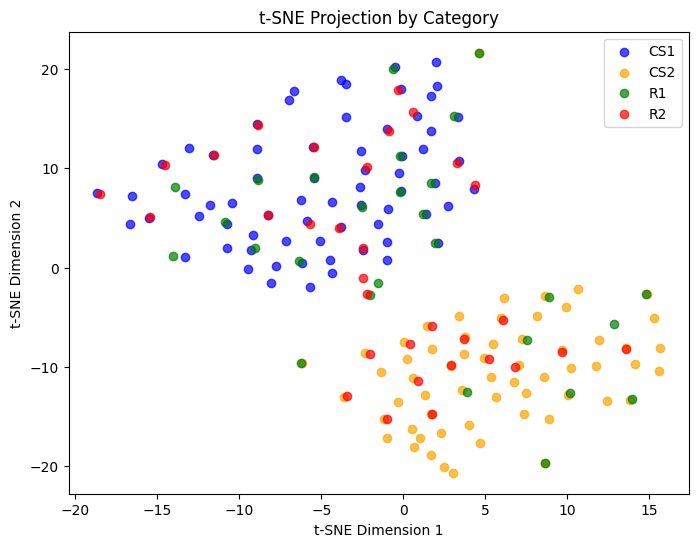

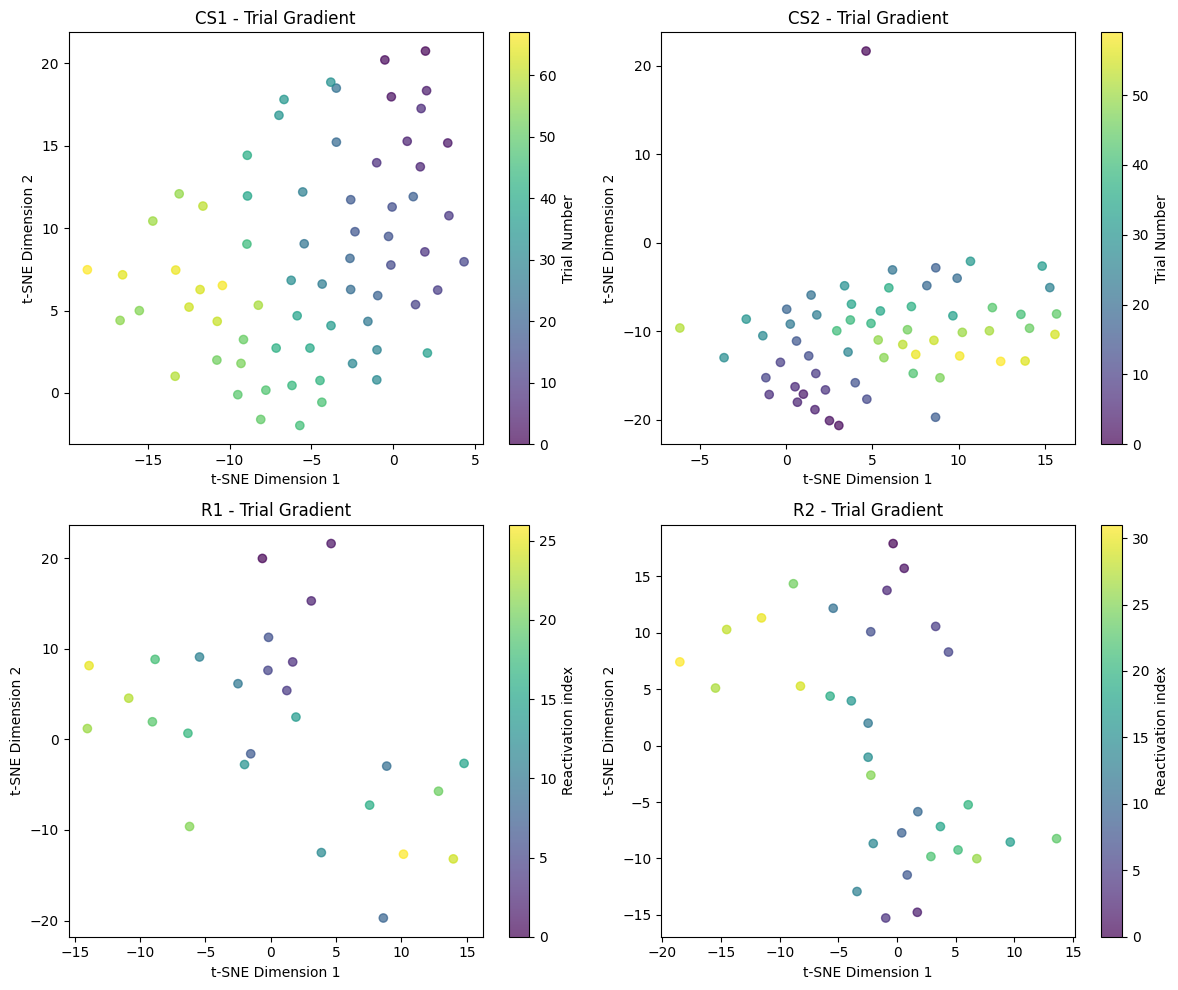

In [ ]:
all_dat = np.concatenate([sers, reacts])
print("t-SNE Analysis for all dat:")
all_dat_tsne = perform_tsne(all_dat)

# number of samples per category
n_cs1 = mean_activity_cs_1.shape[0]
n_cs2 = mean_activity_cs_2.shape[0]
n_r1  = mean_activity_r_1.shape[0]
n_r2  = mean_activity_r_2.shape[0]

cs1_tsne = all_dat_tsne[:n_cs1, :]
cs2_tsne = all_dat_tsne[n_cs1:n_cs1+n_cs2, :]
r1_tsne  = all_dat_tsne[n_cs1+n_cs2:n_cs1+n_cs2+n_r1, :]
r2_tsne  = all_dat_tsne[n_cs1+n_cs2+n_r1:, :]

# different colors for each category
plt.figure(figsize=(8, 6))
plt.scatter(cs1_tsne[:, 0], cs1_tsne[:, 1], alpha=0.7, label="CS1", color='blue')
plt.scatter(cs2_tsne[:, 0], cs2_tsne[:, 1], alpha=0.7, label="CS2", color='orange')
plt.scatter(r1_tsne[:, 0],  r1_tsne[:, 1],  alpha=0.7, label="R1",  color='green')
plt.scatter(r2_tsne[:, 0],  r2_tsne[:, 1],  alpha=0.7, label="R2",  color='red')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Projection by Category")
plt.legend()
plt.show()

# trial gradient for each category
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# CS1: Color by trial order (using np.arange for trial indices)
sc = axs[0, 0].scatter(cs1_tsne[:, 0], cs1_tsne[:, 1],
                         c=np.arange(n_cs1), cmap='viridis', alpha=0.7)
axs[0, 0].set_title("CS1 - Trial Gradient")
axs[0, 0].set_xlabel("t-SNE Dimension 1")
axs[0, 0].set_ylabel("t-SNE Dimension 2")
plt.colorbar(sc, ax=axs[0, 0], label="Trial Number")

# CS2
sc = axs[0, 1].scatter(cs2_tsne[:, 0], cs2_tsne[:, 1],
                         c=np.arange(n_cs2), cmap='viridis', alpha=0.7)
axs[0, 1].set_title("CS2 - Trial Gradient")
axs[0, 1].set_xlabel("t-SNE Dimension 1")
axs[0, 1].set_ylabel("t-SNE Dimension 2")
plt.colorbar(sc, ax=axs[0, 1], label="Trial Number")

# R1
sc = axs[1, 0].scatter(r1_tsne[:, 0], r1_tsne[:, 1],
                         c=np.arange(n_r1), cmap='viridis', alpha=0.7)
axs[1, 0].set_title("R1 - Trial Gradient")
axs[1, 0].set_xlabel("t-SNE Dimension 1")
axs[1, 0].set_ylabel("t-SNE Dimension 2")
plt.colorbar(sc, ax=axs[1, 0], label="Reactivation index")

# R2
sc = axs[1, 1].scatter(r2_tsne[:, 0], r2_tsne[:, 1],
                         c=np.arange(n_r2), cmap='viridis', alpha=0.7)
axs[1, 1].set_title("R2 - Trial Gradient")
axs[1, 1].set_xlabel("t-SNE Dimension 1")
axs[1, 1].set_ylabel("t-SNE Dimension 2")
plt.colorbar(sc, ax=axs[1, 1], label="Reactivation index")

plt.tight_layout()
plt.show()




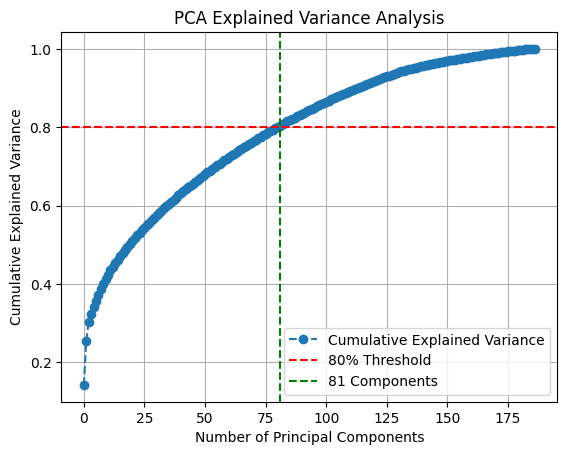

Number of components to explain 80% variance: 81


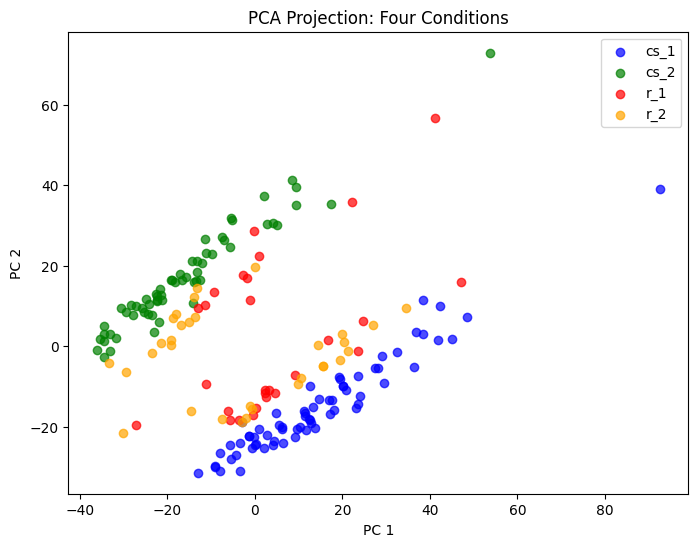

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Combine data from the four conditions
# mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, and mean_activity_r_2 are assumed to be defined arrays
all_data = np.concatenate([mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, mean_activity_r_2])
labels = (['cs_1'] * mean_activity_cs_1.shape[0] +
          ['cs_2'] * mean_activity_cs_2.shape[0] +
          ['r_1']  * mean_activity_r_1.shape[0]  +
          ['r_2']  * mean_activity_r_2.shape[0])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_data)

# Perform PCA
pca = PCA()
pca.fit(data_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.80) + 1
projected_data = pca.transform(data_scaled)[:, :num_components]

# Plot explained variance ratio
plt.figure()
plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Threshold')
plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Analysis')
plt.legend()
plt.grid()
plt.show()

print(f"Number of components to explain 80% variance: {num_components}")

# For the scatter plot, use only the first two principal components
pca_2d = projected_data[:, :2]

# Define colors for each condition
color_dict = {
    'cs_1': 'blue',
    'cs_2': 'green',
    'r_1': 'red',
    'r_2': 'orange'
}

plt.figure(figsize=(8, 6))
# Plot each group separately using its designated color
for group in np.unique(labels):
    idx = [i for i, label in enumerate(labels) if label == group]
    plt.scatter(pca_2d[idx, 0], pca_2d[idx, 1], 
                c=color_dict[group], alpha=0.7, label=group)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Projection: Four Conditions")
plt.legend()
plt.show()


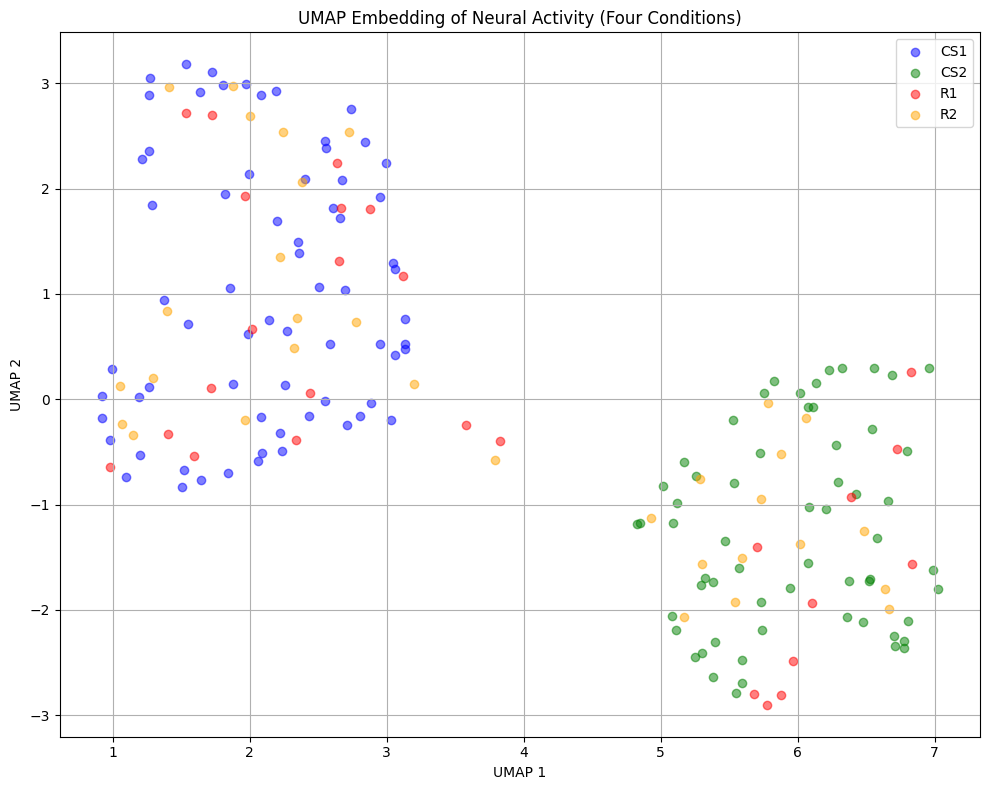

In [38]:
import umap.umap_ as umap

# UMAP Embedding
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(all_data)

# Split the embedding into four groups based on original order
cs1_emb = embedding[:len(mean_activity_cs_1)]
cs2_emb = embedding[len(mean_activity_cs_1) : len(mean_activity_cs_1) + len(mean_activity_cs_2)]
r1_emb = embedding[len(mean_activity_cs_1) + len(mean_activity_cs_2) : len(mean_activity_cs_1) + len(mean_activity_cs_2) + len(mean_activity_r_1)]
r2_emb = embedding[len(mean_activity_cs_1) + len(mean_activity_cs_2) + len(mean_activity_r_1):]

# Plot UMAP embedding with distinct colors for each group
plt.figure(figsize=(10, 8))
plt.scatter(cs1_emb[:, 0], cs1_emb[:, 1], alpha=0.5, label='CS1', color='blue')
plt.scatter(cs2_emb[:, 0], cs2_emb[:, 1], alpha=0.5, label='CS2', color='green')
plt.scatter(r1_emb[:, 0], r1_emb[:, 1], alpha=0.5, label='R1', color='red')
plt.scatter(r2_emb[:, 0], r2_emb[:, 1], alpha=0.5, label='R2', color='orange')

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Embedding of Neural Activity (Four Conditions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Reordered reacts shape: (59, 3124)


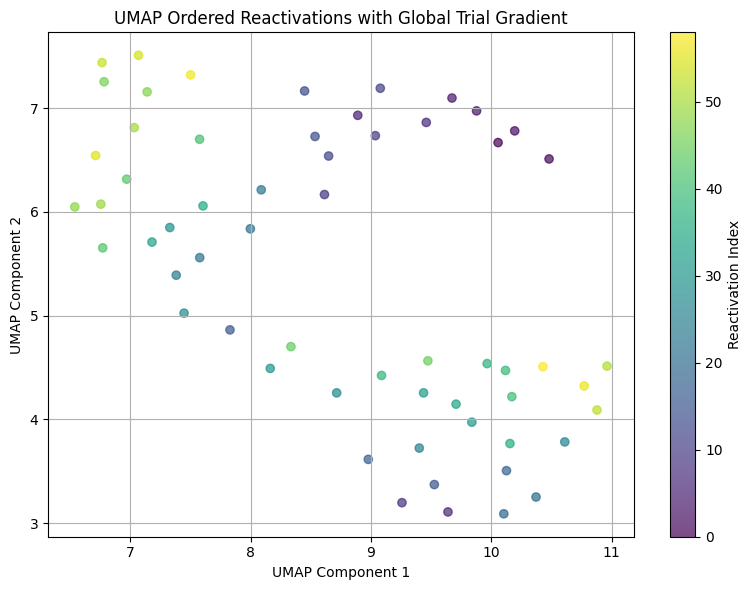

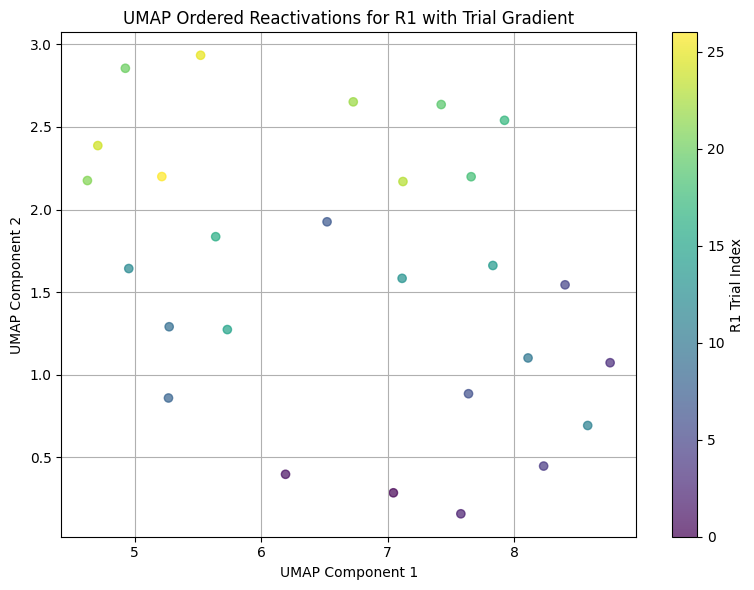

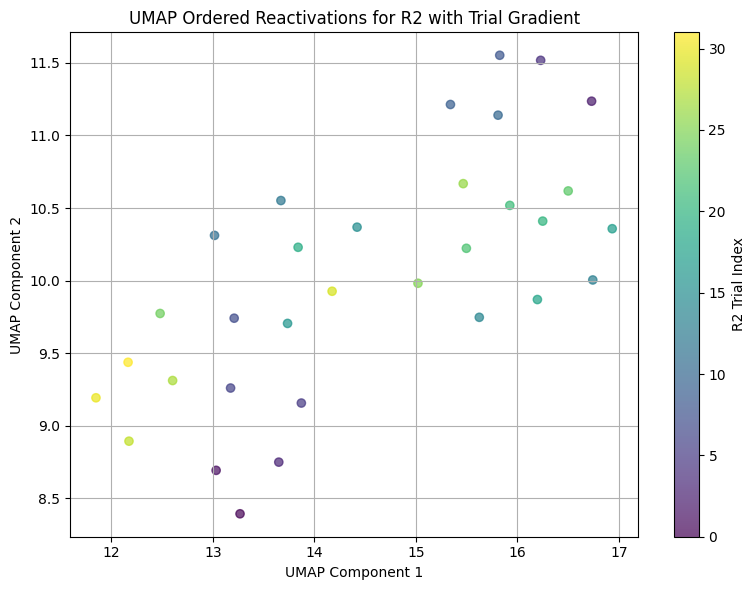

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap

# --- Global UMAP Plot for All Reactivations ---

# Combine all trial numbers and reactivation data
all_trials = np.concatenate([trial_r_1, trial_r_2])
all_reacts = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)

# Obtain ordering indices that sort the trials (using a stable sort to preserve order)
order_idx = np.argsort(all_trials, kind='mergesort')

# Reorder the reactivation data based on the trial order
reacts_ordered = all_reacts[order_idx, :]
print("Reordered reacts shape:", reacts_ordered.shape)

# Create a global trial index for color mapping
trial_numbers = np.arange(reacts_ordered.shape[0])

# Initialize UMAP reducer and compute the embedding
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
reacts_embedding = reducer.fit_transform(reacts_ordered)

# Global UMAP plot with color gradient across all reactivations
plt.figure(figsize=(8, 6))
sc = plt.scatter(reacts_embedding[:, 0], reacts_embedding[:, 1],
                 c=trial_numbers, cmap='viridis', alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Ordered Reactivations with Global Trial Gradient')
cbar = plt.colorbar(sc)
cbar.set_label('Reactivation Index')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Separate UMAP Plots with Color Gradients Per Category ---

# For reactivation group R1
order_idx_r1 = np.argsort(trial_r_1, kind='mergesort')
reacts_r1_ordered = mean_activity_r_1[order_idx_r1, :]
trial_numbers_r1 = np.arange(reacts_r1_ordered.shape[0])
embedding_r1 = reducer.fit_transform(reacts_r1_ordered)

plt.figure(figsize=(8, 6))
sc1 = plt.scatter(embedding_r1[:, 0], embedding_r1[:, 1],
                  c=trial_numbers_r1, cmap='viridis', alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Ordered Reactivations for R1 with Trial Gradient')
cbar1 = plt.colorbar(sc1)
cbar1.set_label('R1 Trial Index')
plt.grid(True)
plt.tight_layout()
plt.show()


# For reactivation group R2
order_idx_r2 = np.argsort(trial_r_2, kind='mergesort')
reacts_r2_ordered = mean_activity_r_2[order_idx_r2, :]
trial_numbers_r2 = np.arange(reacts_r2_ordered.shape[0])
embedding_r2 = reducer.fit_transform(reacts_r2_ordered)

plt.figure(figsize=(8, 6))
sc2 = plt.scatter(embedding_r2[:, 0], embedding_r2[:, 1],
                  c=trial_numbers_r2, cmap='viridis', alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Ordered Reactivations for R2 with Trial Gradient')
cbar2 = plt.colorbar(sc2)
cbar2.set_label('R2 Trial Index')
plt.grid(True)
plt.tight_layout()
plt.show()


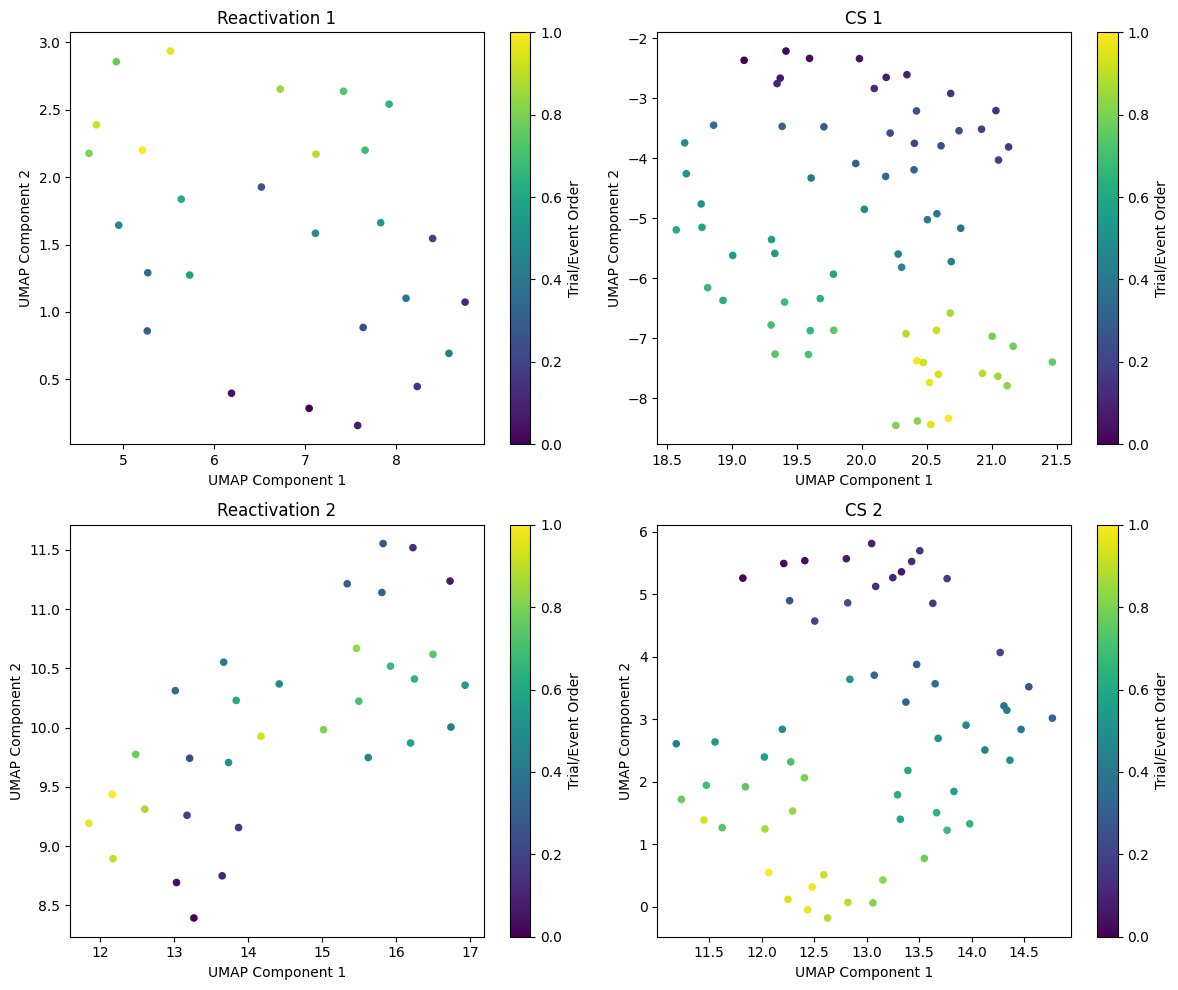

In [40]:
#UMAP per category

umap_embedding_r_1  = reducer.fit_transform(mean_activity_r_1)

umap_embedding_cs_1 = reducer.fit_transform(mean_activity_cs_1)

umap_embedding_r_2 = reducer.fit_transform(mean_activity_r_2)

umap_embedding_cs_2 = reducer.fit_transform(mean_activity_cs_2)

def scatter_with_gradient(embedding, title, ax):
    n = embedding.shape[0]
    # Create an array for the trial/event order
    trial_order = np.linspace(0, 1, n)
    # Create a scatter plot with color gradient based on trial/event order
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=trial_order, cmap='viridis', s=20)
    ax.set_title(title)
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    # Add a colorbar to indicate trial/event order
    plt.colorbar(sc, ax=ax, label='Trial/Event Order')

# Create a 2x2 grid for separate plots
fig, axes = plt.subplots(2, 2, figsize=(12,10))

scatter_with_gradient(umap_embedding_r_1, "Reactivation 1", axes[0, 0])
scatter_with_gradient(umap_embedding_cs_1, "CS 1", axes[0, 1])
scatter_with_gradient(umap_embedding_r_2, "Reactivation 2", axes[1, 0])
scatter_with_gradient(umap_embedding_cs_2, "CS 2", axes[1, 1])

plt.tight_layout()
plt.show()





# rank - order plot

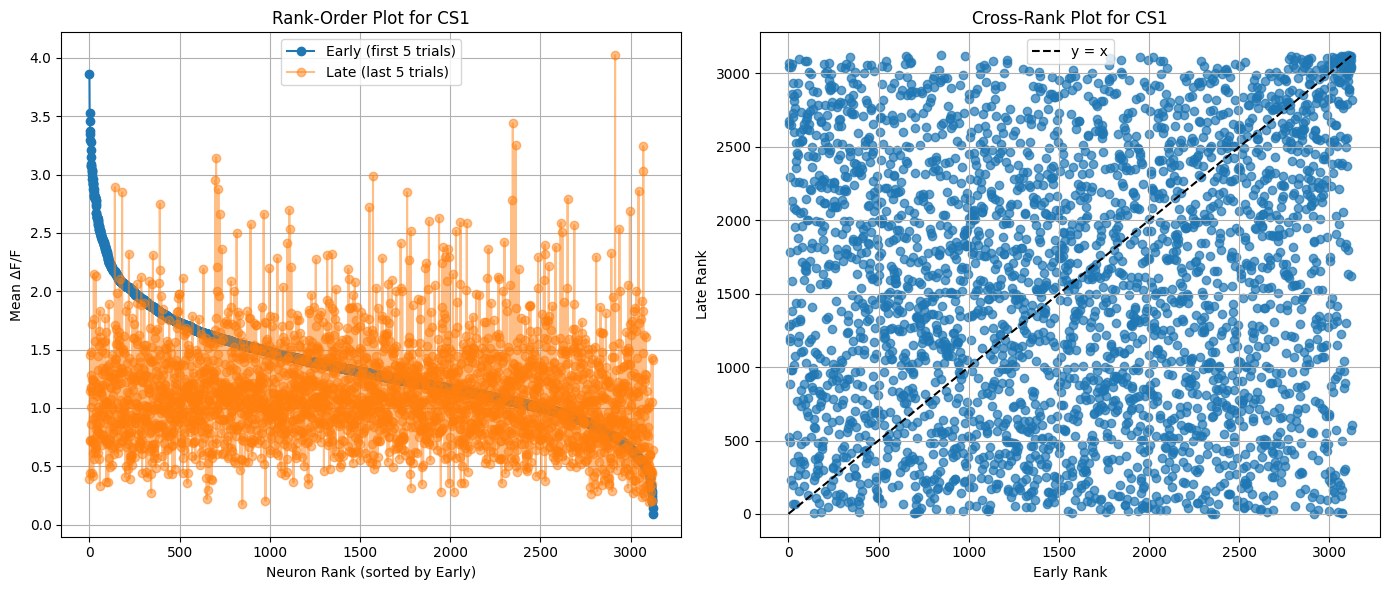

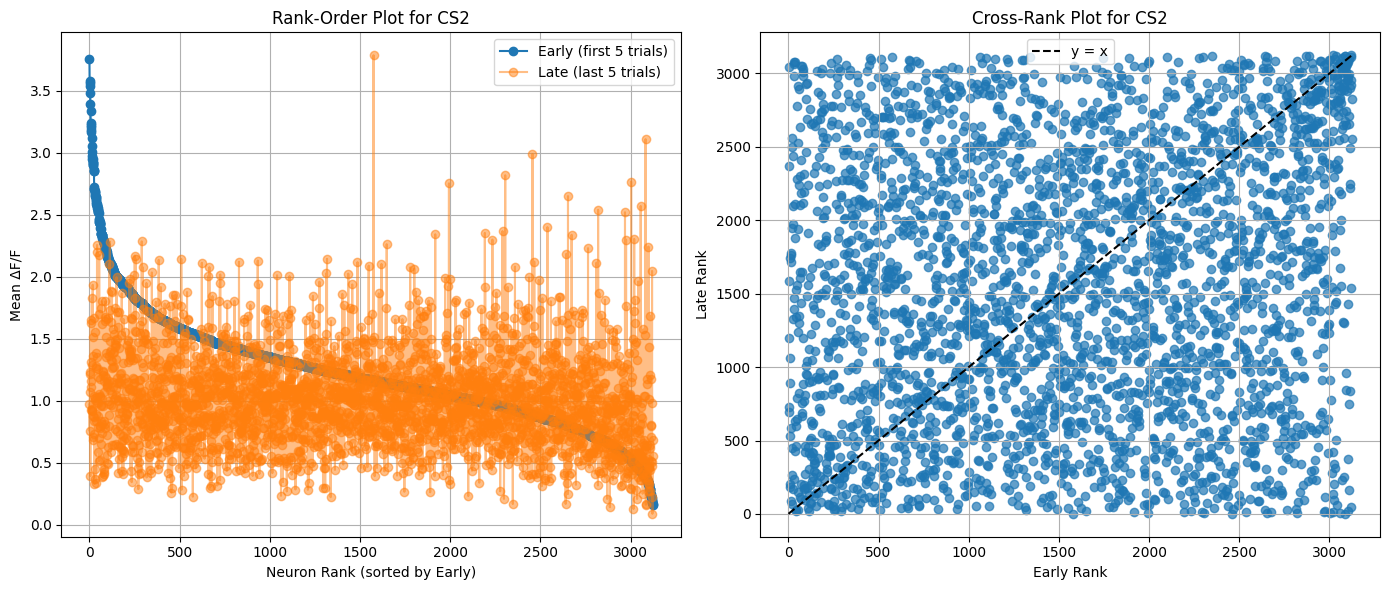

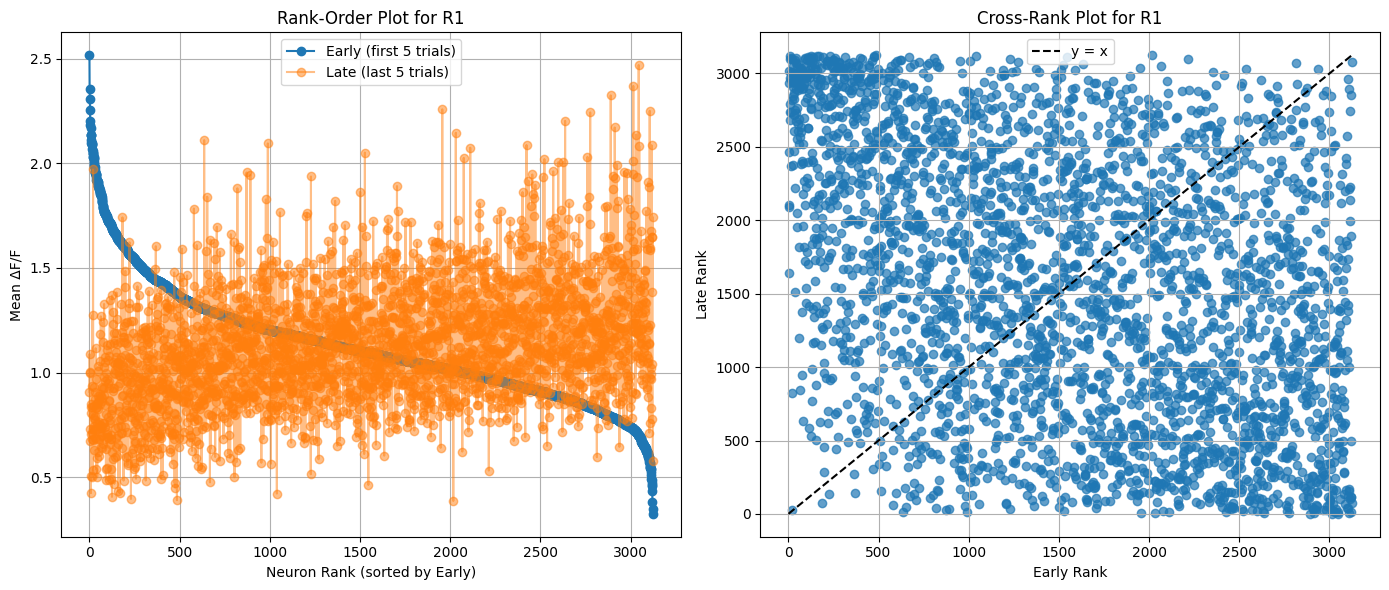

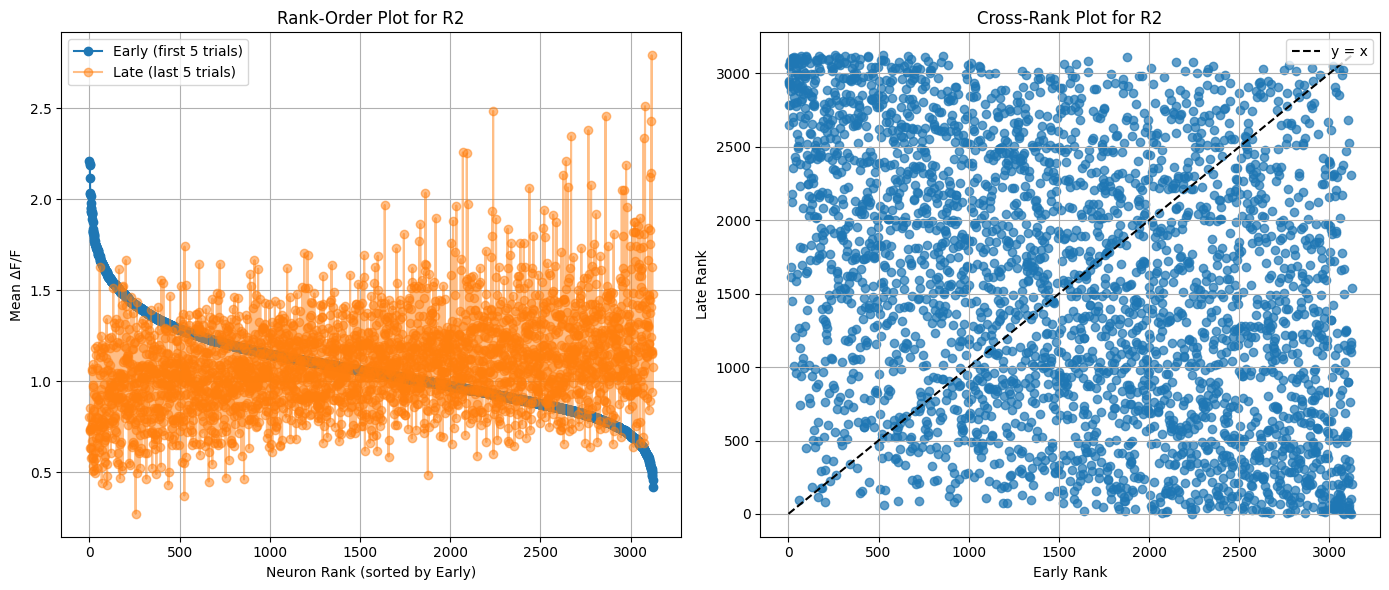

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_early_late_means(data, n_trials=5):
    """
    Compute the average response across the first n_trials and the last n_trials.
    
    Parameters:
      data: 2D numpy array (trials x neurons)
      n_trials: number of trials to average at the beginning and end (default=5)
      
    Returns:
      early_mean: 1D array of mean activity for each neuron (first n_trials)
      late_mean: 1D array of mean activity for each neuron (last n_trials)
    """
    early_mean = np.mean(data[:n_trials, :], axis=0)
    late_mean = np.mean(data[-n_trials:, :], axis=0)
    return early_mean, late_mean

def plot_combined_rank_plots(early, late, condition_name):
    """
    Creates a combined figure with:
      - Left: Rank-order plot of early and late averages (sorted by early).
      - Right: Cross-rank scatter plot (plotting each neuron's rank in early vs. late).
    
    Parameters:
      early: 1D array of early mean responses.
      late: 1D array of late mean responses.
      condition_name: string name of the condition.
    """
    n_neurons = len(early)
    
    # For rank-order plot, sort neurons by early responses (descending)
    sort_idx = np.argsort(early)[::-1]
    early_sorted = early[sort_idx]
    late_sorted = late[sort_idx]
    
    # Compute ranks (1 = highest)
    ranks_early = np.empty(n_neurons, dtype=float)
    ranks_late = np.empty(n_neurons, dtype=float)
    sorted_idx_early = np.argsort(early)[::-1]
    sorted_idx_late = np.argsort(late)[::-1]
    ranks_early[sorted_idx_early] = np.arange(1, n_neurons + 1)
    ranks_late[sorted_idx_late] = np.arange(1, n_neurons + 1)
    
    # Create a figure with two subplots side by side.
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left subplot: Rank-Order Plot
    axs[0].plot(early_sorted, marker='o', linestyle='-', label='Early (first 5 trials)')
    axs[0].plot(late_sorted, marker='o', linestyle='-', label='Late (last 5 trials)', alpha=0.5)
    axs[0].set_xlabel('Neuron Rank (sorted by Early)')
    axs[0].set_ylabel('Mean ΔF/F')
    axs[0].set_title(f'Rank-Order Plot for {condition_name}')
    axs[0].legend()
    axs[0].grid(True)
    
    # Right subplot: Cross-Rank Scatter Plot
    axs[1].scatter(ranks_early, ranks_late, alpha=0.7)
    axs[1].plot([1, n_neurons], [1, n_neurons], 'k--', label='y = x')
    axs[1].set_xlabel('Early Rank')
    axs[1].set_ylabel('Late Rank')
    axs[1].set_title(f'Cross-Rank Plot for {condition_name}')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Create a dictionary for conditions
conditions = {
    'CS1': mean_activity_cs_1,
    'CS2': mean_activity_cs_2,
    'R1': mean_activity_r_1,
    'R2': mean_activity_r_2
}

# Process each condition and create the combined plots:
for cond_name, data in conditions.items():
    early_mean, late_mean = compute_early_late_means(data, n_trials=5)
    plot_combined_rank_plots(early_mean, late_mean, cond_name)
